In [7]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [8]:
# reading tables

In [9]:
ac_details = pd.read_excel('Data Science Case study Vindiata.xls', sheet_name=1, 
                           header=3, index_col=0,usecols='B:F')
ac_details.sample(5)

,Range (Km),Ave. Speed (km/h),Number of Seats,Costs per flight hour
Aircraft Type,,,,
Q400,1500,750,90,3500
A330,8000,900,250,7500
B747,10000,900,350,12000
B737,5000,800,150,5100
A320,5000,800,150,5000


In [10]:
operations = pd.read_excel('Data Science Case study Vindiata.xls', sheet_name=2, skiprows=3, usecols='B:O')
operations.sample(5)

,Aircraft Name,Aircraft Type,2014-01-01 00:00:00,2014-02-01 00:00:00,2014-03-01 00:00:00,2014-04-01 00:00:00,2014-05-01 00:00:00,2014-06-01 00:00:00,2014-07-01 00:00:00,2014-08-01 00:00:00,2014-09-01 00:00:00,2014-10-01 00:00:00,2014-11-01 00:00:00,2014-12-01 00:00:00
13,N,B737,245,246,243,248,238,240,243,241,251,251,246,247
9,J,A330,310,311,308,313,303,305,308,306,316,316,311,312
10,K,B737,250,251,248,253,243,245,248,246,256,256,251,252
18,S,A330,310,311,308,313,303,305,308,306,316,316,311,312
15,P,A320,245,246,243,248,238,240,243,241,251,251,246,247


In [11]:
city_pairs = pd.read_excel('Data Science Case study Vindiata.xls', sheet_name=3, header=3, usecols='B:E')
city_pairs.sample(4)

,Origin City,Desitnation City,Pass. Demand \n(per day),Distance (km)
3,AA,DD,300,1000
1,BB,CC,450,6500
2,CC,AA,300,400
0,AA,BB,420,3000


In [12]:
# renaming ac_detail columns

In [13]:
ac_details.rename(columns = {'Costs per flight hour':r'Costs per flight hour (USD)'}, inplace = True)

In [14]:
# modifying column labels of operations DF and setting appropriate index

In [15]:
# separating date column labels and converting into list
date_lab = operations.columns.astype(object).tolist()[2:]

# converting the date column labels into specified format
date_list = [datetime.strftime(col,'%b-%y') for col in date_lab]

# final date column label
operations.columns = ['Aircraft Name', 'Aircraft Type'] + date_list

In [16]:
# creating multilevel column
operations.set_index(['Aircraft Name', 'Aircraft Type'], inplace=True) 
columns = [('Hours flown', 'Jan-14'), ('Hours flown', 'Feb-14'), 
            ('Hours flown','Mar-14'), ('Hours flown', 'Apr-14'),
           ('Hours flown', 'May-14'), ('Hours flown', 'Jun-14'),
           ('Hours flown', 'Jul-14'), ('Hours flown','Aug-14'),
           ('Hours flown','Sep-14'), ('Hours flown','Oct-14'),
           ('Hours flown','Nov-14'), ('Hours flown','Dec-14')]
operations.columns = pd.MultiIndex.from_tuples(columns)

In [17]:
operations.reset_index(inplace=True)

In [18]:
# renaming column label of city_pair DF

In [19]:
city_pairs.rename(columns={'Pass. Demand \n(per day)': 'Pass. Demand (per day)'}, inplace=True)

In [20]:
#-----------------------------------------------------------------------------------------------------------------------------

In [21]:
# PART - A

In [22]:
# 1: Total cost by the aircraft type for the year

In [23]:
# Total hours flown
hours_flown = operations.sort_index(axis=1).groupby('Aircraft Type').sum().sum(axis=1)

In [24]:
total_cost = (hours_flown * ac_details.loc[:,'Costs per flight hour (USD)']).sort_values(ascending=False)

In [25]:
total_cost

Aircraft Type
A330     163755000
B747     132444000
A320      74375000
B737      60261600
Q400      33166000
ATR72     26224000
dtype: int64

In [26]:
# 2: Aircraft with lowest cost per seat per km flown

In [27]:
# calculating total distance travelled by the aircraft
total_distance = hours_flown * ac_details['Ave. Speed (km/h)']

In [28]:
# calculating costs per seat per km
cost_seat_km = (total_cost / ac_details['Number of Seats']) / total_distance

In [29]:
# aircraft with lowest cost per seat per km flown
ac_lowest_rate = cost_seat_km.sort_values().index[0]

In [30]:
ac_lowest_rate

'A330'

In [31]:
#-----------------------------------------------------------------------------------------------------------------------------

In [32]:
# PART - B

In [33]:
# defining a function to calculate total cost incurred by an aircraft to operate between two cities
def operating_cost(k):
    
    # creating a list of aircrafts that has enough range to operate between two cities
    ac_ind = [ ac_details.index[i] for i in range(ac_details.index.size) \
              if ac_details.iloc[i,0] >= city_pairs.loc[k,'Distance (km)']]
    
    # calculating number of trips to be made by eligible aircrafts
    ntrip = [np.ceil(city_pairs.at[k,'Pass. Demand (per day)'] / ac_details.at[aircraft,'Number of Seats']) \
             .astype(int) for aircraft in ac_ind]
    
    # calculating operating cost for eligible aircrafts assuming availability of multiple aircrafts of each type
    oper_cost = [ac_details.at[ac_ind[i],'Costs per flight hour (USD)'] * ((ntrip[i] * city_pairs.at[k,'Distance (km)']) /
                              ac_details.at[ac_ind[i],'Ave. Speed (km/h)']) for i in range(len(ac_ind))]
    
    # creating a DataFrame with operating costs of all eligible aircraft
    df_cost = pd.DataFrame(list(zip(ac_ind, ntrip, oper_cost)), \
                           columns=['Aircraft Type', 'Number of Trips', 'Operating Cost'])
    
    return df_cost.sort_values(by='Operating Cost').reset_index(drop=True)

In [34]:
ideal_combo = pd.Series({city_pairs.iat[i,0] + '-' + city_pairs.iat[i,1]: operating_cost(i).at[0,'Aircraft Type'] 
               for i in range(city_pairs.index.size)},name='Choice of Aircraft')

In [35]:
ideal_combo

AA-BB    A330
BB-CC    A330
CC-AA    A320
AA-DD    A320
Name: Choice of Aircraft, dtype: object

In [36]:
#-----------------------------------------------------------------------------------------------------------------------------

In [37]:
# Report:

In [38]:
# Create a Pandas Excel writer object using XlsxWriter as the engine.
writer_obj = pd.ExcelWriter('Airline Report.xlsx',engine='xlsxwriter')
workbook_obj = writer_obj.book

In [39]:
bold_it = workbook_obj.add_format({'bold':True,'italic':True})

In [40]:
# Part A

0

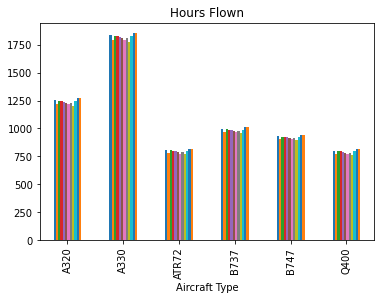

In [41]:
operations.sort_index(axis=1).groupby('Aircraft Type').sum().to_excel(writer_obj, sheet_name = 'Airline A', 
                                                                      startrow=1, startcol=1)
worksheet_obj1 = writer_obj.sheets['Airline A']
worksheet_obj1.set_column('B:B',15)
worksheet_obj1.set_column('C:C',20)
worksheet_obj1.set_header('Airline A')

from io import BytesIO
imgdata = BytesIO()
fig = operations.sort_index(axis=1).groupby('Aircraft Type').sum().plot(kind='bar', title='Hours Flown', legend=False)
fig.get_figure().savefig('imgdata1.png')
worksheet_obj1.insert_image("P1",'imgdata1.png', {'x_scale':0.6, 'y_scale':0.6})

worksheet_obj1.write('B12', 'Comment 1: A330 has the been flown for maximum hours followed by A320 while ATR72 and Q400 has been used the least.',
                    bold_it)

# Comment 1: A330 has the been flown for maximum hours followed by A320 while ATR72 and Q400 has been used the least.

0

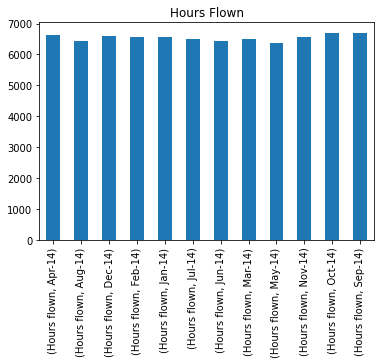

In [42]:
hr_flown = operations.sort_index(axis=1).groupby('Aircraft Type').sum().sum()
hr_flown.name = 'Hours Flown'
hr_flown.droplevel(0).to_excel(writer_obj, sheet_name = 'Airline A', startrow=18, startcol=1)

imgdata = BytesIO()
fig = operations.sort_index(axis=1).groupby('Aircraft Type').sum().sum().plot(kind='bar', title='Hours Flown', legend=False)
fig.get_figure().savefig('imgdata2.png')
worksheet_obj1.insert_image("F17",'imgdata2.png', {'x_scale':0.7, 'y_scale':0.7})

worksheet_obj1.write('L23','Comment 2: Airline A has maintained almost consistent flight time throughout the year.', bold_it)
    
# Comment 2: Airline A has maintained almost consistent flight time throughout the year.

0

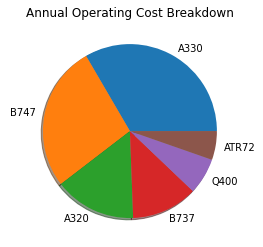

In [43]:
total_cost.name = 'Operating Cost'
total_cost.to_excel(writer_obj, sheet_name = 'Airline A',startrow=37, startcol=1)

imgdata = BytesIO()
fig = total_cost.plot(kind='pie', title='Annual Operating Cost Breakdown', ylabel = ' ', shadow=True)
fig.get_figure().savefig('imgdata3.png')
worksheet_obj1.insert_image("E34",'imgdata3.png', {'x_scale':0.7, 'y_scale':0.7})

worksheet_obj1.write('K40','Comment 3: Flight type A330 has the highest annual operating cost while ATR72 has the least operating cost.',
                    bold_it)
worksheet_obj1.write('K41','Comment 4: Flight type A330 and B747 makes up for more than 50% of the total operating cost for Airline A.',
                    bold_it)

# Comment 3: Flight type A330 has the highest annual operating cost while ATR72 has the least operating cost.
# Comment 4: Flight type A330 and B747 makes up for more than 50% of the total operating cost for Airline A.

0

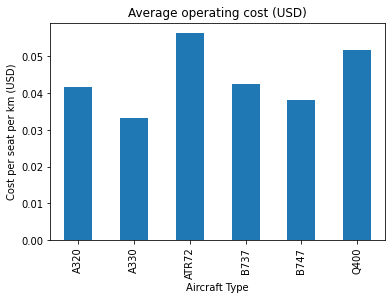

In [44]:
cost_seat_km.name = 'Cost per seat per km'
cost_seat_km.to_excel(writer_obj, sheet_name = 'Airline A',startrow=51, startcol=1)

imgdata = BytesIO()
fig = cost_seat_km.plot(kind='bar', ylabel='Cost per seat per km (USD)', title='Average operating cost (USD)')
fig.get_figure().savefig('imgdata4.png')
worksheet_obj1.insert_image("E50",'imgdata4.png', {'x_scale':0.7, 'y_scale':0.7})

worksheet_obj1.write('K55','Comment 5: For airline A, flight type A330 has the lowest operating cost per seat per km.',bold_it)
worksheet_obj1.write('K56','Comment 6: ATR72 has the highest operating cost per seat per km.',bold_it)

# Comment 5: For airline A, flight type A330 has the lowest operating cost per seat per km 
            # while ATR72 has the highest operating cost per seat per km.

In [45]:
#-----------------------------------------------------------------------------------------------------------------------------

In [46]:
# Part B

0

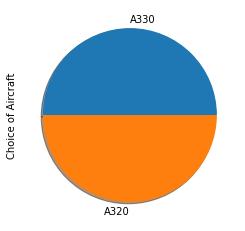

In [47]:
ideal_combo.to_excel(writer_obj, sheet_name = 'Airline B', startrow=1, startcol=1)
worksheet_obj2 = writer_obj.sheets['Airline B']
worksheet_obj1.set_column('C:C',20)

imgdata = BytesIO()
fig = ideal_combo.value_counts().plot(kind='pie', shadow=True)
fig.get_figure().savefig('imgdata5.png')
worksheet_obj2.insert_image("D1",'imgdata5.png', {'x_scale':0.5, 'y_scale':0.5})

worksheet_obj2.write('H4','Comment 1: Only A320 and A330 should be used by Airline B to achieve lowest opearting cost.', bold_it)
worksheet_obj2.write('H5','Comment 2: For route CC-AA and AA-DD use A320', bold_it)
worksheet_obj2.write('H6','Comment 3: For route AA-BB and BB-CC use A330', bold_it)

In [48]:
writer_obj.save()